In [11]:
import json
import matplotlib.pyplot as plt
from collections import Counter
import math
import numpy as np
import polyline
import folium
from datetime import datetime

# MAP

In [37]:
# INTERACTIVE MAP
import os
# I want to take all activities by type and see the history which activity I did the most
f = open('Data/data_detailed.json')
data_detailed = json.load(f)

#create map
map = folium.Map(location=[46.3097, 11.6007], zoom_start=9, tiles='OpenStreetMap', control_scale=True)


# Function to generate a link to download the GPX track

def generate_download_link(coordinates, name):
    # Generate the GPX file name based on the hike name
    gpx_filename = f'GPX/{name.replace(" ", "_").lower()}_track.gpx'
    
    # Generate the content of the GPX file
    gpx_data = '<?xml version="1.0" encoding="UTF-8"?>\n<gpx version="1.1" creator="Gianluca Fava">\n<trk>\n<trkseg>\n'
    for lat, lon in coordinates:
        gpx_data += f'<trkpt lat="{lat}" lon="{lon}"/>\n'
    gpx_data += '</trkseg>\n</trk>\n</gpx>'
    
    # Write the content of the GPX file to disk
    with open(gpx_filename, 'w') as file:
        file.write(gpx_data)

    # Generate the link to download the GPX file
    download_link = f'<a href="{gpx_filename}" download="{gpx_filename}">GPX track</a>'
    
    return download_link


# extracting from data all the data needed
for hike in data_detailed:
    if hike['type'] == 'Hike':
        name = hike['name']
        distance = round(hike['distance'] / 1000, 2) #it's in meter usually
        height_difference =  hike['total_elevation_gain']
        max_height = hike['elev_high']
        color_hike = hike['color']
        polyline_code = hike['map']['polyline']

        #decoding coordinates, those are encoded
        coordinates = polyline.decode(polyline_code) 

        # check if 'photos is void'
        if hike.get('photos') and len(hike['photos']) > 0:
            # Formatting popup text with additional data with photo
            photo = hike['photos'][0]['urls']['1800']
            
            text_popup = f"""
                <span style="font-size: 15px;"><strong>{name}</strong></span>
                <img src="{photo}" alt="Immagine" style="max-width: 240px; max-height: 240px; width: auto; height: auto; margin: auto; display: block;">
                <p>Distance: {distance} km<br>
                Height Difference: {height_difference} m<br>
                Max height reached: {max_height} m<br>
                Download the track here: {generate_download_link(coordinates, name)}</p>
            """
            
        else:
            # Formatting popup text with additional data without photo
            text_popup = f"""
                <span style="font-size: 15px;"><strong>{name}</strong></span><br>
                Distance: {distance} km<br>
                Height Difference: {height_difference} m<br>
                Max height reached: {max_height} m<br>
                Download the track here: {generate_download_link(coordinates, name)}
            """
        
        # Add polyline with popup to the map
        folium.PolyLine(
            locations=coordinates,
            color=color_hike,
            popup=folium.Popup(text_popup, max_width=250, min_width=100, max_height=360, min_height=200)
        ).add_to(map)

        custom_icon = """
        <div style="width: 35px; height: 30px; display: flex; justify-content: center; align-items: flex-start; margin-bottom: 10000px; margin-right: 100px;">
        <svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 67.19 118.35000000000001" x="0px" y="0px" width="40px" height="40px">
          <title>HikePin</title>
          <path fill="{color_hike}" d="M51.2,3.66A33.59,33.59,0,0,0,17.62,37.24s-2.1,25.45,33.56,61.1c29.91-29.9,33.25-52.63,33.55-59.17,0-.64.06-1.28.06-1.93A33.59,33.59,0,0,0,51.2,3.66Zm.33,13.47a3.72,3.72,0,1,1-3.72,3.72A3.73,3.73,0,0,1,51.53,17.13Zm-14.85,17,1.85-8.06a1.6,1.6,0,0,1,1.92-1.2l3,.68a1.61,1.61,0,0,1,1.2,1.93l-1.85,8.05a1.61,1.61,0,0,1-1.92,1.21l-3-.68A1.61,1.61,0,0,1,36.68,34.16Zm8,20.48a2.2,2.2,0,1,1-4.29-1l2.71-11.79c.05.07.09.14.15.21L46.66,46Zm10.12-.47a2.2,2.2,0,0,1-4.4,0v-6.6l-.1-.09-5.52-6.25a3.39,3.39,0,0,1-.9-3.12l2.36-10.26a3.38,3.38,0,0,1,4-2.52,3.06,3.06,0,0,1,.75.28,2.12,2.12,0,0,1,.85.58l3.53,4h4a2.2,2.2,0,1,1,0,4.4h-5a2.2,2.2,0,0,1-1.76-.9L52,33l-1.53,6.67c0,.13-.08.24-.12.36L54,44.18a2.49,2.49,0,0,1,.54,1.09,2.18,2.18,0,0,1,.23.95Zm11-26.11L59.31,56a.77.77,0,0,1-.91.56.75.75,0,0,1-.56-.9l6.42-27.95a.75.75,0,0,1,1.47.34Z"/>
        </svg>
        """.format(color_hike=color_hike)
        
        icon_anchor = (23, 30)  # Adjust x,y position in the map
        
        #I want to place a marker for each start of track
        marker = folium.Marker(
            location=[coordinates[0][0], coordinates[0][1]],
            popup=folium.Popup(text_popup, max_width=250, min_width=100, max_height=360, min_height=200),
            icon=folium.DivIcon(html=custom_icon, icon_anchor=icon_anchor),
            tooltip=name)
        marker.add_to(map)

# ADD LEGEND

#basic icon (no color)
custom_icon_no_color = """
<div style="width: 35px; height: 30px; display: flex; justify-content: center;">
<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 67.19 118.35000000000001" x="0px" y="0px" width="40px" height="40px">
  <title>HikePin</title>
  <path fill="{colorIcon}" d="M51.2,3.66A33.59,33.59,0,0,0,17.62,37.24s-2.1,25.45,33.56,61.1c29.91-29.9,33.25-52.63,33.55-59.17,0-.64.06-1.28.06-1.93A33.59,33.59,0,0,0,51.2,3.66Zm.33,13.47a3.72,3.72,0,1,1-3.72,3.72A3.73,3.73,0,0,1,51.53,17.13Zm-14.85,17,1.85-8.06a1.6,1.6,0,0,1,1.92-1.2l3,.68a1.61,1.61,0,0,1,1.2,1.93l-1.85,8.05a1.61,1.61,0,0,1-1.92,1.21l-3-.68A1.61,1.61,0,0,1,36.68,34.16Zm8,20.48a2.2,2.2,0,1,1-4.29-1l2.71-11.79c.05.07.09.14.15.21L46.66,46Zm10.12-.47a2.2,2.2,0,0,1-4.4,0v-6.6l-.1-.09-5.52-6.25a3.39,3.39,0,0,1-.9-3.12l2.36-10.26a3.38,3.38,0,0,1,4-2.52,3.06,3.06,0,0,1,.75.28,2.12,2.12,0,0,1,.85.58l3.53,4h4a2.2,2.2,0,1,1,0,4.4h-5a2.2,2.2,0,0,1-1.76-.9L52,33l-1.53,6.67c0,.13-.08.24-.12.36L54,44.18a2.49,2.49,0,0,1,.54,1.09,2.18,2.18,0,0,1,.23.95Zm11-26.11L59.31,56a.77.77,0,0,1-.91.56.75.75,0,0,1-.56-.9l6.42-27.95a.75.75,0,0,1,1.47.34Z"/>
</svg>
</div>
"""

# Giving personalized color to the icons
custom_icon_blue = custom_icon_no_color.format(colorIcon='blue')
custom_icon_red = custom_icon_no_color.format(colorIcon='red')

#create legenda html, at the end I added the color of the icon
legenda_html = """
<div style="position: fixed; 
            bottom: 40px; left: 5px; width: 140px; 
            border:4px solid grey; z-index:9000; font-size:13px;
            background-color:white;
            ">&nbsp;
              &nbsp; <span style="display: flex; align-items: center; margin-bottom: -25px; margin-top: -10px;"> {custom_icon_blue} <span style="margin-left: 5px;">Hike</span></span> <br>
              &nbsp; <span style="display: flex; align-items: center; margin-bottom: -5px;">{custom_icon_red} <span style="margin-left: 5px;">Via Ferrata</span></span> <br>
</div>
""".format(custom_icon_blue=custom_icon_blue, 
           custom_icon_red=custom_icon_red)

map.get_root().html.add_child(folium.Element(legenda_html))

map.save('map_polyline2.html')

# Analysis

In [36]:
import json
from datetime import datetime
from collections import Counter

# Function to save data to a JSON file
def save_to_json(data, file_path):
    with open(file_path, 'w') as f:
        json.dump(data, f)

# Function to filter activities by month
def filter_activities_by_month(data, current_date):
    month_activities = []
    for activity in data:
        activity_date = datetime.strptime(activity['start_date'], "%Y-%m-%dT%H:%M:%SZ")
        if current_date.month == activity_date.month:
            month_activities.append(activity['type'])
    return month_activities

# Function to calculate monthly distance for runs
def calculate_monthly_distance(data):
    runs = []
    for activity in data:
        if activity['type'] == 'Run':
            runs.append(activity)
            
    monthly_distance = {}
    for activity in runs:
        activity_date = datetime.strptime(activity['start_date'], "%Y-%m-%dT%H:%M:%SZ")
        month_year = activity_date.strftime("%Y-%m")
        distance = activity['distance'] / 1000
        monthly_distance[month_year] = monthly_distance.get(month_year, 0) + distance
        
    return monthly_distance    

# Open the detailed activity data file
with open('Data/data_detailed.json') as f:
    data_detailed = json.load(f)

current_date = datetime.now() # Get today's date

# Filter activities types for the current month
month_activities = filter_activities_by_month(data_detailed, current_date)
activity_counts = Counter(month_activities) # Count occurrences of each activity type in the current month
save_to_json(activity_counts, 'Data/month_activity.json') # Save the activity counts to a JSON file

# Filter runs of all time 
monthly_distance_run = calculate_monthly_distance(data_detailed)# Calculate monthly distance for runs of all time
save_to_json(monthly_distance_run, 'Data/monthly_distance_run.json') # Save monthly distance for runs to a JSON file

distance 15.0494
elevation_gain 6.482
distance 19.415599999999998
elevation_gain 11.935
distance 10.500200000000001
elevation_gain 7.02
distance 12.1706
elevation_gain 6.834
distance 16.8427
elevation_gain 5.247000000000001
distance 12.315
elevation_gain 11.148
distance 13.395100000000001
elevation_gain 5.985
distance 11.943
elevation_gain 12.991
distance 22.483400000000003
elevation_gain 20.724
distance 17.8308
elevation_gain 10.409
distance 13.4396
elevation_gain 7.961
distance 10.7728
elevation_gain 8.788
distance 11.0993
elevation_gain 17.785
distance 2.16
elevation_gain 0.306
distance 10.2565
elevation_gain 4.593999999999999
distance 2.6601999999999997
elevation_gain 0.7759999999999999
distance 14.7311
elevation_gain 5.0
distance 14.2201
elevation_gain 7.558
distance 9.3322
elevation_gain 9.213
distance 12.036700000000002
elevation_gain 9.208
distance 15.2215
elevation_gain 10.752
distance 12.473
elevation_gain 6.5760000000000005
distance 13.8245
elevation_gain 12.102
distance 9.1

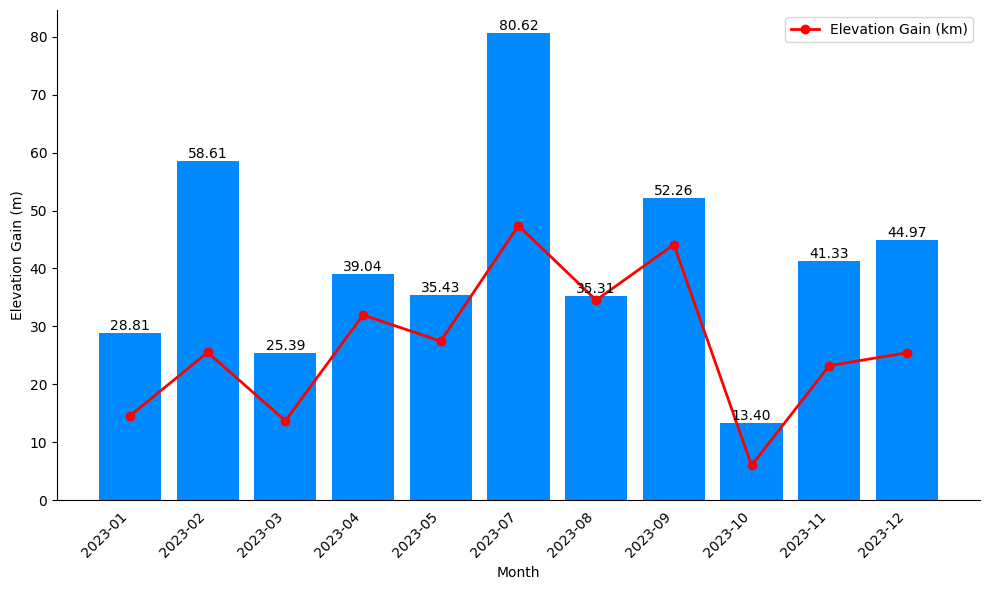

In [34]:
import matplotlib.pyplot as plt
import json
from datetime import datetime

def bar_plot_km_year(year):
    # Open the JSON file and load the data
    with open('Data/data_detailed.json') as f:
        data_detailed = json.load(f)
        
    list_activity = []
    
    # Filter activities for hikes and the specified year
    for activity in data_detailed:
        if activity['type'] == 'Hike' and datetime.strptime(activity['start_date'], "%Y-%m-%dT%H:%M:%SZ").year == year:
            list_activity.append(activity)
            
    return list_activity


# Get the date of today
current_date = datetime.now()

year = 2023
list_activity = bar_plot_km_year(year)

# Initialize a dictionary to count kilometers and elevation gain per month
monthly_distance = {}
monthly_elevation_gain = {}

# Calculate kilometers and elevation gain for each month
for activity in list_activity:
    activity_date = datetime.strptime(activity['start_date'], "%Y-%m-%dT%H:%M:%SZ")
    month_year = activity_date.strftime("%Y-%m")  # Extract the year and month as the key
    distance = activity['distance'] / 1000  # Convert distance from meters to kilometers
    elevation_gain = activity['total_elevation_gain'] / 100 # Elevation gain in meters
    print('distance', distance)
    print('elevation_gain', elevation_gain)
    if month_year in monthly_distance:
        monthly_distance[month_year] += distance
        monthly_elevation_gain[month_year] += elevation_gain
    else:
        monthly_distance[month_year] = distance
        monthly_elevation_gain[month_year] = elevation_gain

# Extract labels (months) and values (distances) from the dictionaries
months = list(monthly_distance.keys())
months = sorted(months, reverse=False)
distances = [monthly_distance[month] for month in months]
elevation_gains = [monthly_elevation_gain[month] for month in months]

# Define custom color (sky blue with adjusted brightness)
sky_blue = '#008AFE'  # Adjusted brightness

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(months, distances, color=sky_blue)

# Customize the appearance of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.xlabel('Month')
plt.ylabel('Kilometers Hike')
plt.xticks(rotation=45, ha='right')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='x', which='both', bottom=False, top=False)

# Add a line plot for elevation gain
plt.plot(months, elevation_gains, color='red', marker='o', linestyle='-', linewidth=2, label='Elevation Gain (km)')
plt.ylabel('Elevation Gain (m)')
plt.legend()

plt.tight_layout()

# Save the plot
plt.savefig('Figure/km_month_hike.jpg', bbox_inches='tight')

# Show the plot
plt.show()


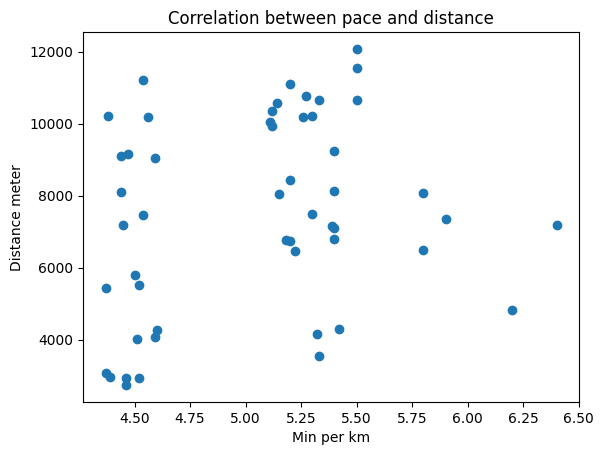

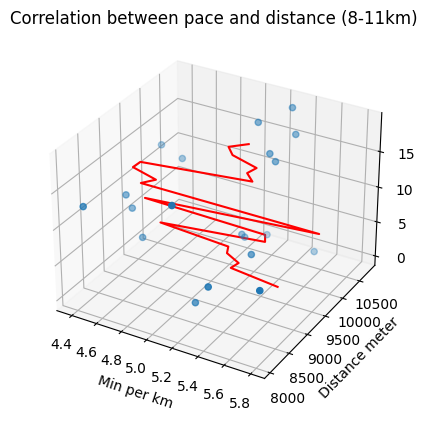

In [6]:
# My focus will be on running 
# I want to know average of km done in a session (there's no average time in downloaded data)
'''
IDEA:

moving_time = 2705 
distance = 8445.9

pace_km_sec = 2705/8,45 = 320,12
pace_km_min = 320,12 / 60 = 5,34
seconds = 0,34 * 60 = 20,4
pace_km = 5,20
'''
f = open('data.json')
data = json.load(f)

run_activities = []   # List to store only the run activities

# Filter the data to get only the run activities
for activity in data:
    if activity['type'] == 'Run':
        run_activities.append(activity)

activities = []   # List to store processed run activities

# Process each run
for run in run_activities:
    
    # Combine minutes and seconds to get pace per kilometer
    pace_km_sec = run['moving_time']/(run['distance']/1000)
    pace_km_min = pace_km_sec / 60 
    frac, whole = math.modf(pace_km_min)
    seconds = frac * 60 
    min_per_km = float(f"{whole:.0f}.{seconds:.0f}")
    
    if min_per_km<10 :    #there's 2 activity with a strange min_km (>16min/km) quite impossible
        # Create a dictionary for the processed run activity
        activity = {
            'name': run['name'],
            'distance': run['distance'],
            'moving_time': run['moving_time'],
            'min_km': min_per_km,
            'type': run['type'],
            'id': run['id'],
            'start_date': run['start_date'],
            'map': run['map']
        }

    # Add the processed run activity to the list of activities
    activities.append(activity)
       
# now i want to plot pace per km based on distance run
x = [activity['min_km'] for activity in activities]
y = [activity['distance'] for activity in activities]

plt.scatter(x, y)
plt.xlabel('Min per km')
plt.ylabel('Distance meter')
plt.title('Correlation between pace and distance')
plt.show()

# now i want to plot pace per km based on distance run between 8 and 11 km
selected_activities = [activity for activity in activities if 8000 <= activity['distance'] < 11000]

x = [activity['min_km'] for activity in selected_activities]
y = [activity['distance'] for activity in selected_activities]
z = range(len(selected_activities))  
dates = [datetime.datetime.strptime(activity['start_date'], "%Y-%m-%dT%H:%M:%SZ") for activity in selected_activities]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

coefficients = np.polyfit(x, y, 1) 
polynomial = np.poly1d(coefficients)

y_regression = polynomial(x)

ax.plot(x, y_regression, z, color='red')

ax.set_xlabel('Min per km')
ax.set_ylabel('Distance meter')
ax.set_zlabel('Dates')
ax.set_title('Correlation between pace and distance (8-11km)')
plt.show()